# IMDB movie classification

This is the "Hello World" of natural language processing. We have 100,000 movie reviews which are either positive or negative. Our task is to build a classifier.

In [1]:
from fastai.text import *

## Fastai text processing

### Prepare a sample of data

In [2]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/imdb_sample/texts.csv')]

In [3]:
df = pd.read_csv(path/'texts.csv')
df.tail()

,label,text,is_valid
995,negative,There are many different versions of this one ...,True
996,positive,Once upon a time Hollywood produced live-actio...,True
997,negative,Wenders was great with Million $ Hotel.I don't...,True
998,negative,Although a film with Bruce Willis is always wo...,True
999,positive,"A compelling, honest, daring, and unforgettabl...",True


In [4]:
df['text'][0]

"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!"

### Make a databunch

We'll ignore the validation set for now as we're just looking at a sample.

In [5]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

In [6]:
data_lm.save()

(Loading a saved databunch is generally much quicker than generating the databunch from raw text)

In [8]:
data = load_data(path)

### Tokenization in fastai

Tokenization involves converting words into numbers using a vocabulary. Fastai's tokenization takes care of:

- punctuation
- contractions e.g. isn't -> is not, don't -> do not
- data cleaning e.g. if there's HTML

In [9]:
data = TextClasDataBunch.from_csv(path, 'texts.csv')
data.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj sydney , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj tivo for weeks before i watched it . i xxunk a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj yorkers . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj ronde",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first stealth games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - rounded gaming experience in general . xxmaj with graphics",positive
"xxbos i really wanted to love this show . i truly , honestly did . \n \n xxmaj for the first time , gay viewers get their own version of the "" xxmaj the xxmaj bachelor "" . xxmaj with the help of his obligatory "" hag "" xxmaj xxunk , xxmaj james , a good looking , well - to - do thirty - something has the chance",negative


- Special tokens (beginning with xx) replace unknown tokens (see below) or to introduce different text fields

The vocabulary is:

In [12]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

In [35]:
data.train_ds[0][0].text

'xxbos xxmaj you know the story .. xxmaj pretty kids alone in the woods , when xxunk starts cutting them up . \n \n  xxmaj well this crap is no different . a bunch of kids return to a cabin where the male leads twin brother disappeared for years before . xxmaj suddenly an " xxup xxunk xxup creature " stars cutting them up , and their only help is a doctor / biker . \n \n  xxmaj to say this film was bad is an understatement , it \'s xxunk ! xxmaj the acting was horrible . \n \n  xxmaj the creature looked very cheesy . xxmaj and as all films do these days they try to get you with a twist ending , which they do not ! \n \n  xxmaj there is one bright spot to this xxunk xxup lost star xxmaj maggie xxmaj grace as the female lead .'

In [37]:
data.train_ds[0][0].data

array([  2,   5,  34, 148, ...,   9, 727, 432,  11])

### Using the data block API for text in fastai

Parse the columns of the CSV for the labels and validation set

In [38]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch()
       )

## IMDB Review Classifier using Transfer Learning

From here we'll start using the full dataset

### Language model for movie reviews with transfer learning

We're going to use a transfer learning approach by using a model trained on Wikipedia articles. Wikipedia is quite different to movie reviews, so we need to do a little bit of training before using it for classification.

In [39]:
bs = 48

In [40]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/imdb/README'),
 PosixPath('/home/jupyter/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/jupyter/.fastai/data/imdb/unsup'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train'),
 PosixPath('/home/jupyter/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/jupyter/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/jupyter/.fastai/data/imdb/test')]

In [41]:
(path/'train').ls()

[PosixPath('/home/jupyter/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train/neg'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train/pos')]

In [43]:
(path/'unsup').ls()[:10]

[PosixPath('/home/jupyter/.fastai/data/imdb/unsup/43121_0.txt'),
 PosixPath('/home/jupyter/.fastai/data/imdb/unsup/31662_0.txt'),
 PosixPath('/home/jupyter/.fastai/data/imdb/unsup/2655_0.txt'),
 PosixPath('/home/jupyter/.fastai/data/imdb/unsup/39029_0.txt'),
 PosixPath('/home/jupyter/.fastai/data/imdb/unsup/12513_0.txt'),
 PosixPath('/home/jupyter/.fastai/data/imdb/unsup/35966_0.txt'),
 PosixPath('/home/jupyter/.fastai/data/imdb/unsup/35050_0.txt'),
 PosixPath('/home/jupyter/.fastai/data/imdb/unsup/32685_0.txt'),
 PosixPath('/home/jupyter/.fastai/data/imdb/unsup/5972_0.txt'),
 PosixPath('/home/jupyter/.fastai/data/imdb/unsup/26672_0.txt')]

The `unsup` folder contains unlabelled examples. This will be useful for transfer learning from the wikipedia model.

Build the data object

`label_for_lm()` will ignore the labels, shuffle the text examples at each epoch, and concatenate them together. We give the model batches of text, where the target is the next word in the sentence.

This will allow us to build an appropriate language model of movie reviews.

`_lm` for "language model"

In [44]:
data_lm = (TextList.from_folder(path)
                   .filter_by_folder(include=['train', 'test', 'unsu'])  # so we're training on everything for the language model??
                   .split_by_rand_pct(0.1)
                   .label_for_lm()
                   .databunch(bs=bs)
          )
data_lm.save('data_lm.pkl')

In [45]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [46]:
data_lm.show_batch()

idx,text
0,"the rodeo ( say xxmaj xxunk - xxmaj day - oh ) star , both of whom are slightly randy . xxmaj the film follows their adventures , as they try to best each other in the pursuit of the xxmaj mexican xxmaj juanita , and later in their pursuit of perky xxmaj mary xxmaj kornman , who has the inevitable evil brother ( though he 'd been led astray"
1,actually be the worst movie that i have ever scene . xxmaj incoherent would be a compliment . xxmaj even the end made no sense but it was a tremendous relief that it was finally over . i watched it with a kind of fatalistic fascination to see if it could continue to deteriorate and it did . xxmaj by the end of this mess i was sorry any of
2,skip this one . xxbos xxmaj personally i think this show looks pretty cheaply made . xxmaj some of the actors are terrible . xxmaj they over do it & seem fake . i can always tell how it 's going to end within the first 10 minutes or less of watching because they make it so transparently clear . xxmaj it 's not very well written either . i
3,"girl running through a xxmaj forest , scared of something . a car stops and picks her up ( just so being the people she needed to see , amazing ? ) xxmaj they take her back to some xxmaj clinic and examine her , at the xxunk all this is happening her xxmaj father appears at the gates and they do n't allow him in , he is n't"
4,watch this movie ! xxmaj it shows you about every mistake not to do in editing a movie ! xxmaj my grandma could have done better than that ! xxmaj but that 's not the only reason why this movie is really bad ! ( xxmaj it 's actually so bad that i 'm not able to write a sentence without exclamation mark ! ) xxmaj if the first episode


Build and fine tune the model. Using AWD-LSTM from [this paper](https://arxiv.org/pdf/1708.02182.pdf).

In [48]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [ ]:
learn.lr_find()

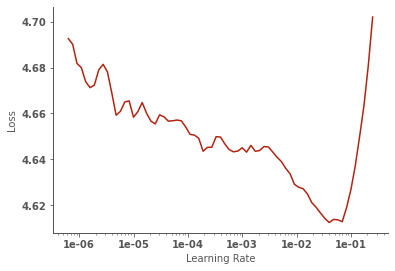

In [59]:
learn.recorder.plot(skip_end=19)

Given that the learning rate we can use here is so big (`1e-2`), looks like there's quite a bit of fine tuning we can do to the model to make it appropriate for movie reviews.

In [62]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.2))  # not sure what moms does

epoch,train_loss,valid_loss,accuracy,time
0,4.117962,4.006266,0.295705,10:32


In [63]:
learn.save('fit-head')

In [64]:
learn.load('fit-head');

To finish the fine-tuning, let's unfreeze the model and do another learning rate search.

In [65]:
learn.unfreeze()

In [ ]:
learn.lr_find()

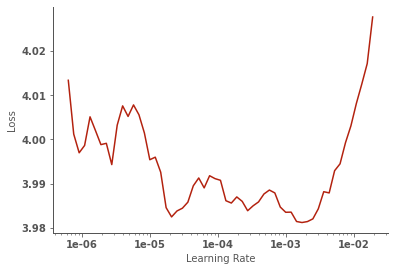

In [68]:
learn.recorder.plot(skip_end=30)

In [69]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.838060,3.847691,0.311847,12:02
1,3.827969,3.802308,0.318810,12:03
2,3.765960,3.774923,0.322698,12:04
3,3.684192,3.743454,0.327079,12:07
4,3.622646,3.728934,0.329541,12:05
5,3.521247,3.716583,0.331106,12:07
6,3.455555,3.713175,0.332374,12:05
7,3.351106,3.715029,0.332960,12:05
8,3.263600,3.725364,0.332315,12:04
9,3.224235,3.731036,0.331923,12:05


In [70]:
learn.save('fine_tuned')

Note that the encoder, which converts words into a fixed-length vector, gets saved separately from the RNN model. It's actually only the encoder that we'll transfer over for the classification task. **Q: Why?**

In [75]:
learn.save_encoder('fine_tuned_enc')

Let's have a look at how good this language model for movie reviews is:

In [72]:
learn.load('fine_tuned');

In [73]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [74]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this movie because it had a great cast , the guys who played the Sheriff and the old Sheriff of Nottingham were great . It was made up of Sheriff 's Cop - Out and
I liked this movie because it was a little slow , but slightly worth watching . It 's not perfect , it just paints a picture as a book not as a movie . The acting was fine , but the plot was


## Train the movie classifier

For our problem, we don't care about generating new words. But the fact that we have a model which is able to create sentences which sound a bit like movie reviews is going to help us build a much better classifier than if we had e.g. trained an RNN from scratch.

In [77]:
path = untar_data(URLs.IMDB)

In [78]:
data_classifier = (TextList.from_folder(path, vocab=data_lm.vocab)
                           .split_by_folder(valid='test')
                           .label_from_folder(classes=['neg', 'pos'])
                           .databunch(bs=bs)
                  )
data_classifier.save('data_classifier.pkl')

In [79]:
data_classifier = load_data(path, 'data_classifier.pkl', bs=bs)

In [80]:
data_classifier.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj how strange the human mind is ; this center of activity wherein perceptions of reality are formed and stored , and in which one 's view of the world hinges on the finely tuned functioning of the brain , this most delicate and intricate processor of all things sensory . xxmaj and how much do we really know of it 's inner - workings , of it 's",pos
"xxbos xxmaj pier xxmaj paolo xxmaj pasolini , or xxmaj pee - pee - pee as i prefer to call him ( due to his love of showing male genitals ) , is perhaps xxup the most overrated xxmaj european xxmaj marxist director - and they are thick on the ground . xxmaj how anyone can see "" art "" in this messy , cheap sex - romp concoction is",neg
"xxbos xxmaj the vigilante has long held a fascination for audiences , inasmuch as it evokes a sense of swift , sure justice ; good triumphs over evil and the bad guy gets his deserts . xxmaj it is , in fact , one of the things that has made the character of xxmaj dirty xxmaj harry xxmaj callahan ( as played by xxmaj clint xxmaj eastwood ) so popular",pos
"xxbos xxmaj anyone who visited drive - ins in the 1950s , 60s , and 70s , must have seen a film or two by xxmaj american xxmaj international xxmaj pictures , a distributor that resembled 1980s giant xxmaj cannon xxmaj films . xxmaj wherever movie - goers ventured , xxup aip would be right there to supply the latest en vogue titles - in the 50s came horror movies",neg


So see now how the mini-batches have a target associated with them, whereas above it was just lists of text.

### Use transfer learning from the fine-tuned AWD-LSTM to build a text classifier

In [82]:
learn = text_classifier_learner(data_classifier, AWD_LSTM, drop_mult=0.5)  # why are we using drop_mult=0.5 now? It was 0.8 before
learn.load_encoder('fine_tuned_enc');

Notice that we're only using the encoder from the step above, and keep the rest of the model as we receive it.

In [83]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


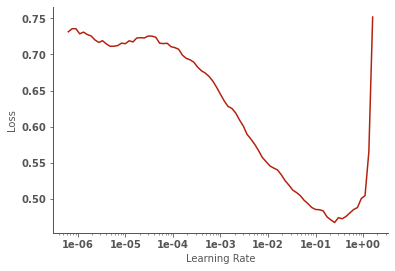

In [84]:
learn.recorder.plot()

In [85]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8, 0.7))  # what's moms?

epoch,train_loss,valid_loss,accuracy,time
0,0.278651,0.196091,0.923960,03:01


Wow -- we're already at 92% accuracy. Compare that to my [super-naive model](https://github.com/jaryaman/tensorflow-2-tutorial/blob/master/notebooks/5-JA-basic-text-classification.ipynb) from the TensorFlow 2 tutorial consisting of just an embedding and a couple dense layers, which only had 81% accuracy.

In [86]:
learn.save('first')

In [87]:
learn.load('first');

In [88]:
learn.freeze_to(-2)  # only train the last 2 layers

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


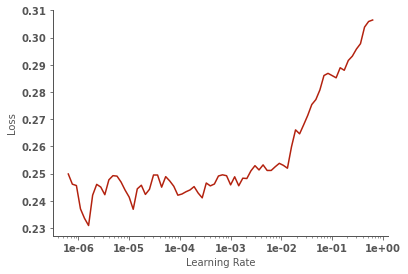

In [89]:
lr_find(learn)
learn.recorder.plot()

In [91]:
learn.fit_one_cycle(1, slice(1e-4, 1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.250983,0.187990,0.928480,03:15


In [92]:
learn.save('second')

In [93]:
learn.load('second');

In [94]:
learn.fit_one_cycle(2, slice(1e-4, 1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.250184,0.181367,0.930320,03:45
1,0.228043,0.177837,0.932840,03:41


In [95]:
learn.save('third')

In [96]:
learn.load('third');

In [97]:
learn.unfreeze()

In [ ]:
lr_find(learn)

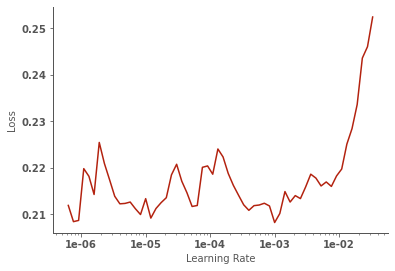

In [102]:
learn.recorder.plot(skip_end=20)

In [103]:
learn.fit_one_cycle(2, slice(1e-5, 1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.226483,0.172966,0.933360,05:17
1,0.205205,0.167985,0.937200,05:36


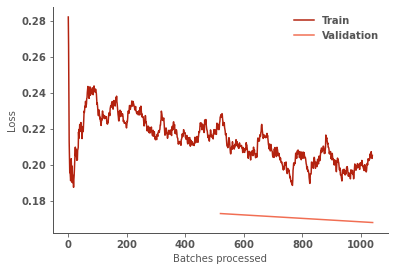

In [104]:
learn.recorder.plot_losses()

In [105]:
learn.save('fourth')

In [106]:
learn.fit_one_cycle(2, slice(1e-5, 1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.192886,0.168149,0.936640,05:20
1,0.188185,0.164001,0.938360,06:05


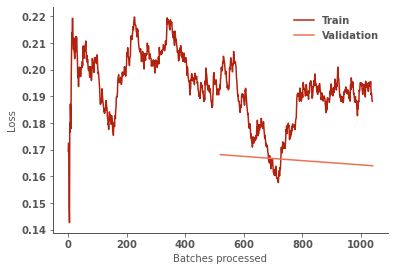

In [107]:
learn.recorder.plot_losses()

That'll do.

In [108]:
learn.save('fifth')

In [110]:
learn.predict("I really loved that movie, it was awesome!")

(Category tensor(1), tensor(1), tensor([0.0026, 0.9974]))

In [111]:
learn.predict("That movie felt like a kick right in my childhood")  # Nope!

(Category tensor(1), tensor(1), tensor([0.1776, 0.8224]))

In [112]:
learn.predict("They could have hired better voice actors")

(Category tensor(0), tensor(0), tensor([0.9264, 0.0736]))

In [113]:
learn.predict("Simply the worst movie I've ever seen, just terrible.")

(Category tensor(0), tensor(0), tensor([9.9967e-01, 3.2677e-04]))